# Imports

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.metrics import classification_report
## estimators
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier,
                              HistGradientBoostingClassifier,
                              BaggingClassifier,
                              AdaBoostClassifier)

# Titanic challenge - kaggle

# Baseline

## Load data

In [81]:
df = pd.read_csv("../data/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [82]:
df.set_index("PassengerId", inplace=True)

In [83]:
df.duplicated().sum()

0

In [84]:
round(df.isnull().sum().sort_values(ascending=False)/len(df)*100)

Cabin       77.0
Age         20.0
Embarked     0.0
Survived     0.0
Pclass       0.0
Name         0.0
Sex          0.0
SibSp        0.0
Parch        0.0
Ticket       0.0
Fare         0.0
dtype: float64

## Handling missing data

In [85]:
# drop Cabin
df.drop(columns=["Cabin"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 76.6+ KB


## Train test split

In [86]:
X = df.drop(columns="Survived")
y = df["Survived"]

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train.shape, y_train.shape

((712, 9), (712,))

## Numerical columns

In [88]:
num_cols = ["Age", "Fare"]

In [89]:
num_transformer = make_pipeline(
    KNNImputer(),
    RobustScaler()
)
num_transformer

Pipeline(steps=[('knnimputer', KNNImputer()), ('robustscaler', RobustScaler())])

## Categorical columns

In [91]:
cat_cols = ["Pclass", "Sex", "SibSp", "Parch", "Embarked"]
cat_cols

['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

In [93]:
X[cat_cols].head(1)

,Pclass,Sex,SibSp,Parch,Embarked
PassengerId,,,,,
1,3,male,1,0,S


In [95]:
cat_transformer = make_pipeline(
    OneHotEncoder(sparse_output=False, handle_unknown="ignore", drop="if_binary")
)
cat_transformer

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(drop='if_binary', handle_unknown='ignore',
                               sparse_output=False))])

## Basic preproc

In [96]:
basic_preproc = make_column_transformer(
    (num_transformer, num_cols),
    (cat_transformer, cat_cols),
    remainder="drop"
)
basic_preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['Age', 'Fare']),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Pclass', 'Sex', 'SibSp', 'Parch',
                                  'Embarked'])])

## Baseline

In [98]:
baseline_pipe = make_pipeline(
    basic_preproc,
    LogisticRegression(max_iter=1000, solver="lbfgs")
)
baseline_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Pclass', 'Sex', 'SibSp',
                                                   'Parch', 'Embarked'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [102]:
cross_val_score(baseline_pipe, X_train, y_train).mean()

/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.8188318723529993

In [103]:
y_pred = baseline_pipe.predict(X_test)

/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [107]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       110
           1       0.75      0.65      0.70        69

    accuracy                           0.78       179
   macro avg       0.77      0.76      0.76       179
weighted avg       0.78      0.78      0.78       179



## First submission

In [108]:
test_df = pd.read_csv("../data/test.csv")
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [109]:
y_pred = baseline_pipe.predict(test_df)

/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [117]:
submission_df = pd.DataFrame({"PassengerId": test_df.PassengerId, "Survived": y_pred})
submission_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [128]:
from datetime import datetime

file_name = f"""sub_{datetime.today().strftime("%d-%m-%Y@%H:%M:%S")}.csv"""
file_name

'sub_03-07-2024@17:16:04.csv'

In [132]:
submission_df.set_index("PassengerId", inplace=True)

In [133]:
submission_df.to_csv(f"../data/submissions/{file_name}")

## SCORE : 0.77

# Finetuning preprocessign

In [136]:
num_cols

['Age', 'Fare']

<AxesSubplot:xlabel='Fare', ylabel='Count'>

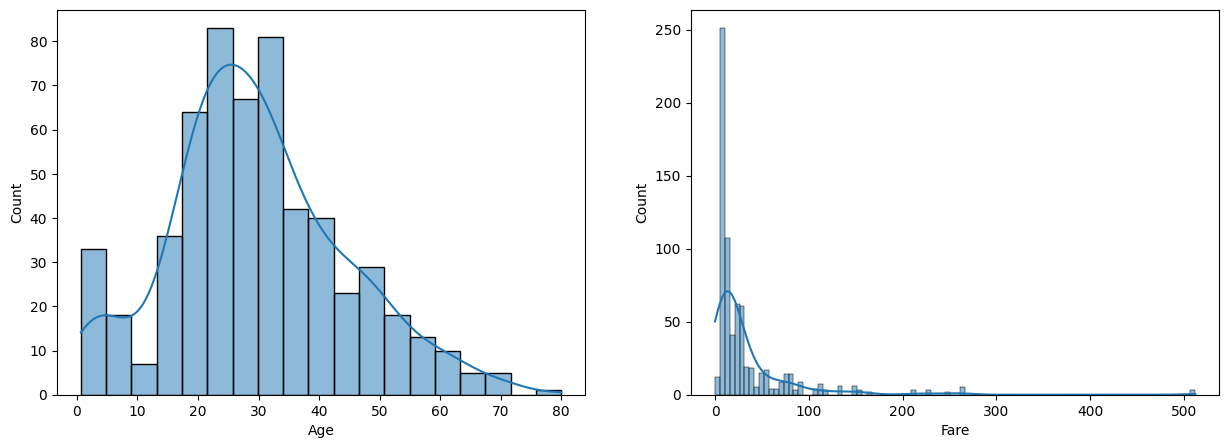

In [138]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

sns.histplot(X_train.Age, kde=True, ax=axs[0])
sns.histplot(X_train.Fare, kde=True, ax=axs[1])

In [142]:
X_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,
309,2,"Abelson, Mr. Samuel",male,30.0,1,0,P/PP 3381,24.000,C
400,2,"Trout, Mrs. William H (Jessie L)",female,28.0,0,0,240929,12.650,S
788,3,"Rice, Master. George Hugh",male,8.0,4,1,382652,29.125,Q
151,2,"Bateman, Rev. Robert James",male,51.0,0,0,S.O.P. 1166,12.525,S
24,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.500,S


# Finding a better estimator

In [145]:
classifiers = [
    LogisticRegression(),
    SVC(),
    RandomForestClassifier(),
    HistGradientBoostingClassifier(),
    BaggingClassifier(),
    AdaBoostClassifier()
]

In [151]:
classifier = classifiers[0]

'LogisticRegression'

In [153]:
res = {
    "classifier": [],
    "score": []
}

for classifier in classifiers:
    pipeline = make_pipeline(
        basic_preproc,
        classifier
    )
    res["classifier"].append(str(classifier).split("(")[0])
    res["score"].append(cross_val_score(pipeline, X_train, y_train).mean())
res

/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/adbla/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be en

{'classifier': ['LogisticRegression',
  'SVC',
  'RandomForestClassifier',
  'HistGradientBoostingClassifier',
  'BaggingClassifier',
  'AdaBoostClassifier'],
 'score': [0.8188318723529993,
  0.8061459667093469,
  0.8047966118388652,
  0.8159952723333005,
  0.792140254112085,
  0.7921599527233331]}